# Monosynaptic pair analysis using existing test-data
-------

Example notebook demonstrating simple functions in SynapticConn for analysing monosynaptically connected spike-trains.

In [1]:
import os
import pathlib
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.chdir('../..')
import synapticonn as synapticonn

Load spike times.

Here, we are loading a series of spike time trains exported from Kilosort 2 and Phy via the [SpikeInterface](https://github.com/SpikeInterface/spikeinterface) package. Additional file types can be used.

In [2]:
data_fpath = pathlib.Path('examples', 'test_datasets', 'data', 'all_unit.mat')

# check if file exists
if not data_fpath.exists():
    raise FileNotFoundError(f"File not found: {data_fpath}")

# open mat file
data = scipy.io.loadmat(data_fpath)

# re-organize data
num_units = len(data['unit_t'][0])
all_units = {}
for i in range(num_units):
    all_units[i] = data['unit_t'][0][i].T[0]

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'unit_t'])

Sanity check the spike trains.

In [3]:
# plot all spike trains
fig, ax = plt.subplots(figsize=(10, 5))
for i, unit in enumerate(all_units):
    ax.eventplot(all_units[unit], lineoffsets=i, linelengths=0.5, linewidths=0.5, color='black')
    
# labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Unit')

# xlims
ax.set_xlim(0, 50)

Initialize the object.

In [ ]:
snc = synapticonn.SynaptiConn(all_units, bin_size_ms=0.5, max_lag_ms=20, srate=20_000, recording_length_ms=1000*1000)

Check the loaded spike units.

In [ ]:
spk_unit_report = snc.report_spike_units()
pd.DataFrame(spk_unit_report)

,unit_id,n_spikes
0,0,3238
1,1,2532
2,2,1167
3,3,1253
4,4,485
5,5,3423
6,6,1253
7,7,1593
8,8,1056
9,9,1771


## Spike isolation quality metrics
----

Prior to proceeding, it is important to cross-check the quality of the spike sorted neurons. 

Metrics related to the spike quality can be found below. Notably, the autocorrelograms for each unit should also be cross-referenced prior to continuing. Low contamination (or no contamination) in the refractory periods are important for correct assesments of spike-units and their monosynaptic connections.

**NOTE** here, more simple and core metric assessments are performed. In the future, these will be extended. For further quality metrics, please see the following [code](https://github.com/SpikeInterface/spikeinterface/blob/main/src/spikeinterface/qualitymetrics/misc_metrics.py#L1183). Further, Allen Brain have core documentation which can be found [here](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html#ISI-violations) explaining some key metrics to assess spike unit quality.

In [ ]:
params = {'isi_threshold_ms': 1.5,
          'min_isi_ms': 0,  # note :: isi min should be based on the miniimum possible refractory period (e.g. spikes removed would constitute this)
          'presence_ratio_bin_duration_ms': 60*1000,
          'presence_ratio_mean_fr_ratio_thresh': 0.0}

qc = snc.spike_unit_quality(**params)
qc

,isi_violations_ratio,isi_violations_rate,isi_violations_count,isi_violations_of_total_spikes,presence_ratio,recording_length_sec,n_spikes,firing_rate_hz
0,95.409375,3.001,3001.0,0.926807,0.058824,1000.0,3238.0,3.238
1,120.157612,2.311,2311.0,0.912717,0.058824,1000.0,2532.0,2.532
2,234.233480,0.957,957.0,0.820051,0.058824,1000.0,1167.0,1.167
3,218.470085,1.029,1029.0,0.821229,0.058824,1000.0,1253.0,1.253
4,459.134871,0.324,324.0,0.668041,0.058824,1000.0,485.0,0.485
5,91.036369,3.200,3200.0,0.934852,0.058824,1000.0,3423.0,3.423
6,216.771581,1.021,1021.0,0.814844,0.058824,1000.0,1253.0,1.253
7,179.168461,1.364,1364.0,0.856246,0.058824,1000.0,1593.0,1.593
8,244.514272,0.818,818.0,0.774621,0.058824,1000.0,1056.0,1.056
9,164.198848,1.545,1545.0,0.872388,0.058824,1000.0,1771.0,1.771


Filter the spike times for 'good units' based on the quality control metrics.

These will then be used for all further processing. The spike times will be updated accordingly.

A log of the excluded units can be found and kept.

In [ ]:
query = 'firing_rate_hz > 0.5'
good_units = snc.filter_spike_units(qc, query, log=True)
good_units

,isi_violations_ratio,isi_violations_rate,isi_violations_count,isi_violations_of_total_spikes,presence_ratio,recording_length_sec,n_spikes,firing_rate_hz
0,95.409375,3.001,3001.0,0.926807,0.058824,1000.0,3238.0,3.238
1,120.157612,2.311,2311.0,0.912717,0.058824,1000.0,2532.0,2.532
2,234.233480,0.957,957.0,0.820051,0.058824,1000.0,1167.0,1.167
3,218.470085,1.029,1029.0,0.821229,0.058824,1000.0,1253.0,1.253
5,91.036369,3.200,3200.0,0.934852,0.058824,1000.0,3423.0,3.423
6,216.771581,1.021,1021.0,0.814844,0.058824,1000.0,1253.0,1.253
7,179.168461,1.364,1364.0,0.856246,0.058824,1000.0,1593.0,1.593
8,244.514272,0.818,818.0,0.774621,0.058824,1000.0,1056.0,1.056
9,164.198848,1.545,1545.0,0.872388,0.058824,1000.0,1771.0,1.771
10,61.090415,5.013,5013.0,0.958509,0.058824,1000.0,5230.0,5.230


Check the updates.

In [ ]:
spk_unit_report = snc.report_spike_units()
pd.DataFrame(spk_unit_report)

,unit_id,n_spikes
0,0,3238
1,1,2532
2,2,1167
3,3,1253
4,5,3423
5,6,1253
6,7,1593
7,8,1056
8,9,1771
9,10,5230


## Auto-correlograms
---

Compute the autocorrelogram for select unit IDs.

Plotting autocorrelogram for spike units: [1 8]


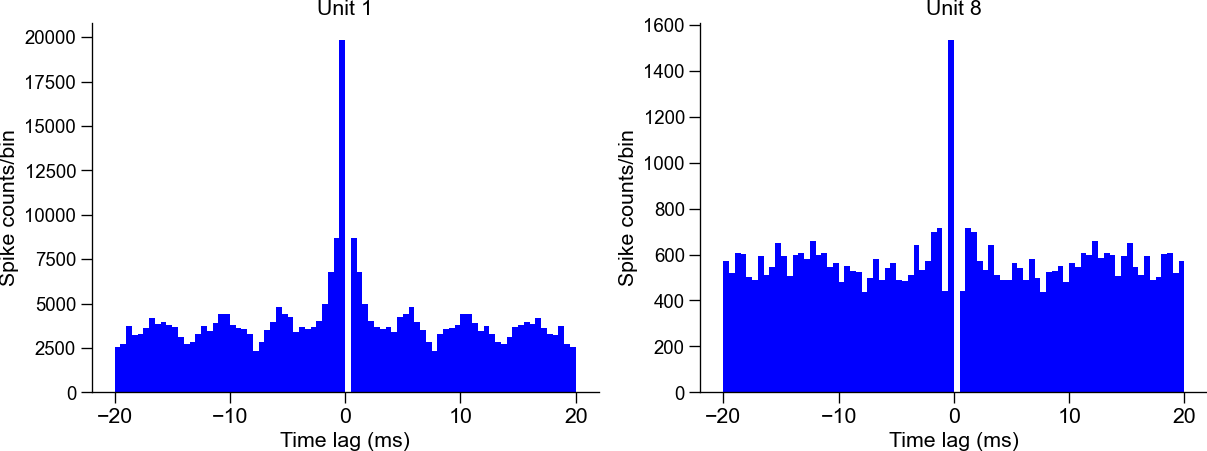

In [ ]:
snc.plot_autocorrelogram(spike_units=[1,8], color='blue')

Set the bin parameters after initialization, and re-plot.

This can be used to change the binning on the plots, and max time lags.

Plotting autocorrelogram for spike units: [ 0  1 10]


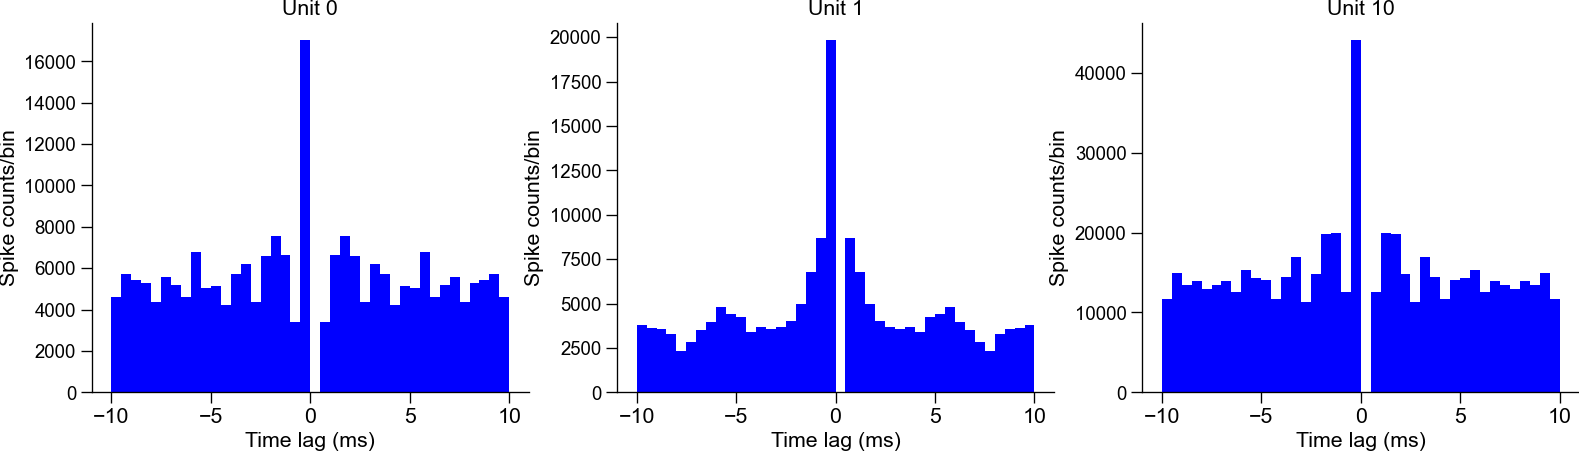

In [ ]:
snc.set_bin_settings(bin_size_ms=0.5, max_lag_ms=10)
snc.plot_autocorrelogram(spike_units=[0,1,10], color='blue', figsize=(20,5))

## Cross-correlograms
----

Visualize cross-correlograms between pairs.

Bin size and time lag can be changed by re-setting the bins. However, for improved visualizations and reporting a smaller bin size and time lag is recommended.

In [ ]:
spk_units = snc.spike_times.keys()

# make a list of all possible pairs
pairs = []
for i, unit1 in enumerate(spk_units):
    for j, unit2 in enumerate(spk_units):
        if i < j:
            pairs.append((unit1, unit2))

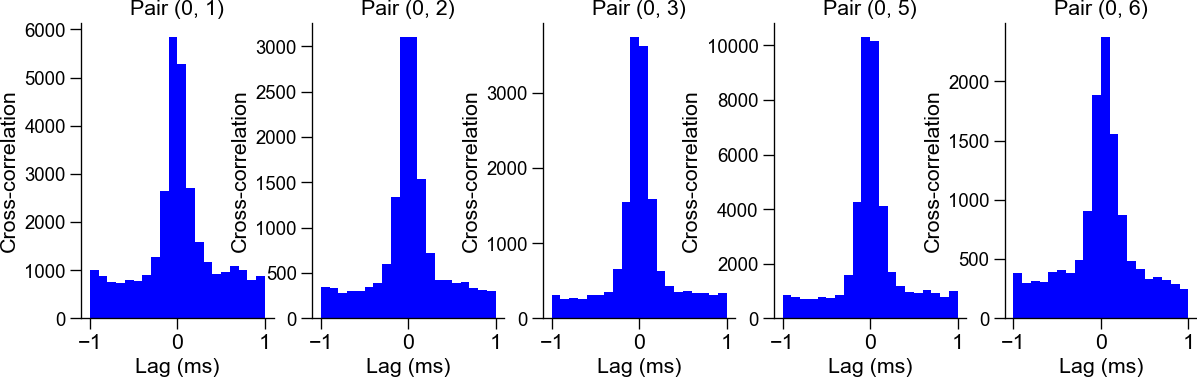

In [ ]:
spike_pairs = pairs[0:5]
snc.plot_crosscorrelogram(spike_pairs=spike_pairs, figsize=(15, 4))

## Return correlogram data
----

Next, try returning the correlogram data.

Each key in 'cross_correlations' is indexed by the unit pairs. The corresponding numbers refer to the spike counts, per bin.

Each key in 'bins' is also indexed by the unit pairs. The corresponding numbers refer to the bins edges.

In [ ]:
correlogram_data = snc.return_crosscorrelogram_data(spike_pairs=spike_pairs)
correlogram_data

{'cross_correllations': {(0,
   1): array([ 998,  875,  759,  734,  795,  772,  908, 1282, 2637, 5849, 5285,
         2708, 1584, 1171,  928,  967, 1078, 1014,  793,  871]),
  (0,
   2): array([ 343,  335,  280,  299,  304,  345,  388,  595, 1333, 3106, 3098,
         1539,  725,  427,  424,  387,  404,  338,  309,  303]),
  (0,
   3): array([ 316,  263,  271,  259,  308,  307,  353,  654, 1542, 3746, 3623,
         1582,  633,  424,  353,  368,  339,  334,  313,  331]),
  (0,
   5): array([  860,   793,   726,   705,   784,   738,   846,  1580,  4251,
         10321, 10160,  4126,  1688,  1182,   965,   939,  1054,   925,
           768,   992]),
  (0,
   6): array([ 383,  296,  318,  303,  391,  407,  384,  491,  906, 1883, 2378,
         1559,  870,  486,  414,  329,  353,  321,  287,  244])},
 'bins': {(0,
   1): array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
          0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
  (0,
   2): array([-1. , -

Check the bin settings using for correlogram generations.

In [ ]:
snc.report_correlogram_settings()

'Bin size: 0.1 ms, Max lag: 1 ms'

## Compute monosynaptic connections 
----

Compute excitatory and inhibitory monosynaptic connections between spike trains. 

This analysis was based on the following reference by Najafi et al., [here](https://www.sciencedirect.com/science/article/pii/S0896627319308487). This protocol was based on data and experimental analyses provided in the following [here](https://www.cell.com/cell-reports/fulltext/S2211-1247(23)01487-0?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2211124723014870%3Fshowall%3Dtrue).

> **computational strength calculations notes**

> First, compute synaptic strength for a set of neuron IDs. If a given unit consistently fires after a second unit, indicated by a peak in the CCG, there is high chance that these cells are functionally linked either directly through an excitatory synaptic connection or indirectly through a third neuron providing a common input.

> To compute synaptic strength, the firing of a single unit in a pair was jittered across a number of iterations (num_iterations) within a time range (jitter_range_ms). 
These were used to calculate a confidence interval (CI) between 1% and 99%. If the real CCG peak passed the 99% CI, the corresponding functional connection would be considered
significant and not random.

> A z-score was then performed using the following equation:

> ```Z = x_real - mean_jitter / std_jitter```

Inspect the output synaptic strength data.

Note that the output contains the following keys: 
1. ccg bins
2. ccg counts (from original spike trains)
3. ccg counts (post jitter)
4. synaptic strength
5. high confidence interval (99%), calculated on jittered ccg
6. low confidence interval (1%), calculation on jittered ccg
7. ccg counts (within jitter range window)
8. low confidence interal (1%), within jitter range window
9. high confidence interal (99%), within jitter range window

In [ ]:
synaptic_strength_data = snc.synaptic_strength(spike_pairs=spike_pairs, num_iterations=1000, jitter_range_ms=10)

Check the synaptic strength data for a select pair.

This can be done automatically by plotting the original ccg, and the z-scored value.

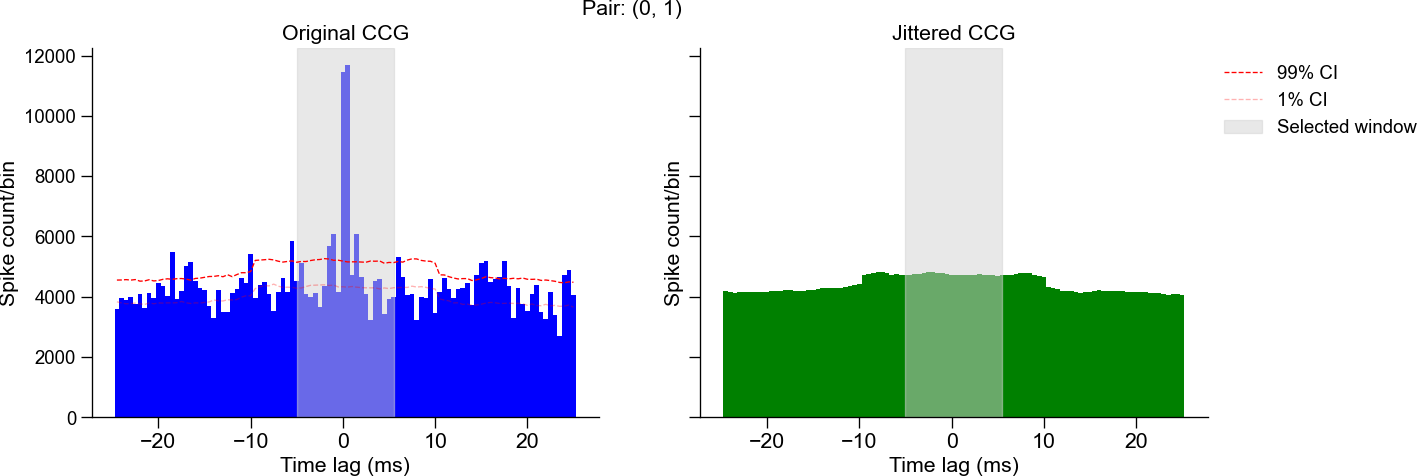

In [ ]:
snc.plot_synaptic_strength(spike_pair = (0,1))

**Next, check the connection type.** 

Here, we can perform a putative detection using the z-score (synaptic strength) output.

Thresholds should be set as > 5 for excitatory-connections, or inhibitory connections as < -5 based on the reference protocol.

In [ ]:
exc_connection_types = snc.monosynaptic_connection_types(threshold = 5)
exc_df = pd.DataFrame(exc_connection_types).T
exc_df

putative_exc_connection_type
0 1      excitatory monosynaptic
  2      excitatory monosynaptic
  3      excitatory monosynaptic
  5      excitatory monosynaptic
  6      excitatory monosynaptic

Output a features dataframe containing selected spike pair connections and associated ccg features.

These can be used to provide simple information on the quality of the CCG, and associated connection types.

In [ ]:
synaptic_features = snc.monosynaptic_connection_features()
synaptic_features_df = pd.DataFrame(synaptic_features).T
synaptic_features_df

synaptic_strength  ccg_peak_time_ms  ccg_peak_count_per_bin  \
0 1          36.650063               0.0                 11676.0   
  2          31.873791               0.0                  6213.0   
  3          33.080458               0.0                  6615.0   
  5          51.332842               0.0                 18121.0   
  6          27.477785               0.0                  5707.0   

     bootstrap_std    ccg_cv  
0 1     118.365086  0.271511  
  2      62.342407  0.322685  
  3      71.825085  0.331253  
  5     190.264270  0.319440  
  6      48.424226  0.228249